In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm', 'On Scene DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['On Scene to Available'] = df['Available DtTm'] - df['On Scene DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']
df['Dispatch to Respond'] = df['Response DtTm'] - df['Dispatch DtTm']


time_cols = ['On Scene to Available', 'Call to Dispatch', 'Dispatch to Respond']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [6]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [7]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= locations

In [12]:
df.shape

(2350000, 45)

In [8]:
df1 = df[(df['On Scene to Available'].notnull()) & (df['On Scene to Available'] <= 21600)  & (df['On Scene to Available'] > 15)]

#only not null, not zero and less 10 hours
#(df['Respond to Available'] <= 36000) 

In [21]:
df1.shape

(1733633, 45)

In [55]:
#------cancelled d
df1 = df1.drop(columns=['Call Number', 'Incident Number', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Address', 'City', 'Priority', 'Final Priority', 
                       'Location', 'RowID', 'Battalion', 'ALS Unit', 'Weekofyear','Month', 'WeekDay',
                        'Original Priority', 'Call Type Group',
                      'Fire Prevention District', 'Supervisor District'], errors='ignore')

In [56]:
df1 = df1.dropna(how='any') 

In [57]:
df1.head()

,Unit ID,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Neighborhooods - Analysis Boundaries,On Scene to Available,Call to Dispatch,Dispatch to Respond,Hours,Minutes,Hospital or Transport,0,1
1,M14,Medical Incident,94122,23,7651.0,1,MEDIC,2,Sunset/Parkside,3861.0,87.0,102.0,21,9,1,37.754033,-122.502186
3,E01,Alarms,94102,1,1456.0,1,ENGINE,3,Tenderloin,247.0,26.0,105.0,21,13,0,37.782547,-122.412248
4,RS1,Medical Incident,94108,1,1322.0,1,RESCUE SQUAD,2,Financial District/South Beach,28.0,101.0,116.0,21,14,0,37.786307,-122.405295
5,T03,Citizen Assist / Service Call,94109,3,1463.0,1,TRUCK,1,Nob Hill,842.0,43.0,120.0,21,24,0,37.788439,-122.414352
6,E38,Electrical Hazard,94109,38,3155.0,1,ENGINE,1,Nob Hill,498.0,171.0,73.0,21,25,0,37.790370,-122.422329


In [58]:
y = df1['On Scene to Available']
X = df1.drop(columns=['On Scene to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118614 entries, 1 to 1665713
Data columns (total 16 columns):
Unit ID                                 1118614 non-null object
Call Type                               1118614 non-null object
Zipcode of Incident                     1118614 non-null int64
Station Area                            1118614 non-null object
Box                                     1118614 non-null float64
Number of Alarms                        1118614 non-null int64
Unit Type                               1118614 non-null object
Unit sequence in call dispatch          1118614 non-null int64
Neighborhooods - Analysis Boundaries    1118614 non-null object
Call to Dispatch                        1118614 non-null float64
Dispatch to Respond                     1118614 non-null float64
Hours                                   1118614 non-null int64
Minutes                                 1118614 non-null int64
Hospital or Transport                   1118614 non-null 

In [60]:
cat_features=[
    0,
    1,
    3,
    6,
    8
]

In [61]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [74]:
model = CatBoostRegressor(iterations=1000, depth=10,learning_rate=0.1)
model.fit(train_pool)

0:	learn: 1984.1722959	total: 2.49s	remaining: 41m 27s
1:	learn: 1847.6126055	total: 4.68s	remaining: 38m 56s
2:	learn: 1728.8052833	total: 7.09s	remaining: 39m 16s
3:	learn: 1625.8706525	total: 9.74s	remaining: 40m 24s
4:	learn: 1536.8098978	total: 12.1s	remaining: 40m 14s
5:	learn: 1460.4185709	total: 14.4s	remaining: 39m 37s
6:	learn: 1394.8837459	total: 16.5s	remaining: 39m 5s
7:	learn: 1339.1086437	total: 18.9s	remaining: 39m 5s
8:	learn: 1291.9406595	total: 21.3s	remaining: 39m 10s
9:	learn: 1252.1387401	total: 23.5s	remaining: 38m 44s
10:	learn: 1219.0553941	total: 25.5s	remaining: 38m 10s
11:	learn: 1190.6031735	total: 27.6s	remaining: 37m 53s
12:	learn: 1167.0831698	total: 29.9s	remaining: 37m 53s
13:	learn: 1147.5446352	total: 32.4s	remaining: 37m 59s
14:	learn: 1131.0927623	total: 34.7s	remaining: 38m
15:	learn: 1116.6907040	total: 36.5s	remaining: 37m 27s
16:	learn: 1104.7492988	total: 38.8s	remaining: 37m 23s
17:	learn: 1094.7916017	total: 40.8s	remaining: 37m 6s
18:	learn

140:	learn: 1002.6844099	total: 10m 22s	remaining: 1h 3m 41s
141:	learn: 1002.6472919	total: 10m 25s	remaining: 1h 3m 26s
142:	learn: 1002.5077219	total: 10m 28s	remaining: 1h 3m 12s
143:	learn: 1002.2289473	total: 10m 30s	remaining: 1h 2m 55s
144:	learn: 1001.8883169	total: 10m 34s	remaining: 1h 2m 46s
145:	learn: 1001.6812432	total: 10m 37s	remaining: 1h 2m 36s
146:	learn: 1001.5363343	total: 10m 41s	remaining: 1h 2m 27s
147:	learn: 1001.4165949	total: 10m 45s	remaining: 1h 2m 20s
148:	learn: 1001.1949307	total: 10m 48s	remaining: 1h 2m 9s
149:	learn: 1001.0820613	total: 10m 51s	remaining: 1h 1m 57s
150:	learn: 1000.9768841	total: 10m 55s	remaining: 1h 1m 48s
151:	learn: 1000.7585044	total: 10m 58s	remaining: 1h 1m 36s
152:	learn: 1000.5633621	total: 11m 1s	remaining: 1h 1m 24s
153:	learn: 1000.4371152	total: 11m 3s	remaining: 1h 1m 11s
154:	learn: 1000.2204436	total: 11m 6s	remaining: 1h 57s
155:	learn: 1000.1239994	total: 11m 9s	remaining: 1h 45s
156:	learn: 1000.0281984	total: 11m

282:	learn: 983.9060367	total: 16m 49s	remaining: 42m 46s
283:	learn: 983.7207035	total: 16m 52s	remaining: 42m 41s
284:	learn: 983.6072281	total: 16m 54s	remaining: 42m 35s
285:	learn: 983.5212364	total: 16m 57s	remaining: 42m 30s
286:	learn: 983.4747199	total: 17m	remaining: 42m 25s
287:	learn: 983.3779538	total: 17m 3s	remaining: 42m 18s
288:	learn: 983.2904519	total: 17m 6s	remaining: 42m 14s
289:	learn: 983.2125648	total: 17m 9s	remaining: 42m 8s
290:	learn: 983.0766502	total: 17m 11s	remaining: 42m 2s
291:	learn: 982.9797646	total: 17m 14s	remaining: 41m 56s
292:	learn: 982.8546883	total: 17m 16s	remaining: 41m 50s
293:	learn: 982.7491490	total: 17m 19s	remaining: 41m 44s
294:	learn: 982.6683464	total: 17m 22s	remaining: 41m 39s
295:	learn: 982.5487921	total: 17m 24s	remaining: 41m 33s
296:	learn: 982.4912880	total: 17m 27s	remaining: 41m 28s
297:	learn: 982.2809400	total: 17m 30s	remaining: 41m 23s
298:	learn: 982.1279837	total: 17m 33s	remaining: 41m 17s
299:	learn: 982.0375543

425:	learn: 970.9988472	total: 22m 27s	remaining: 30m 20s
426:	learn: 970.8794308	total: 22m 30s	remaining: 30m 16s
427:	learn: 970.8136438	total: 22m 32s	remaining: 30m 11s
428:	learn: 970.6549436	total: 22m 35s	remaining: 30m 7s
429:	learn: 970.4860367	total: 22m 37s	remaining: 30m 3s
430:	learn: 970.2977826	total: 22m 40s	remaining: 29m 59s
431:	learn: 970.2004243	total: 22m 42s	remaining: 29m 55s
432:	learn: 970.0117778	total: 22m 44s	remaining: 29m 51s
433:	learn: 969.9776838	total: 22m 47s	remaining: 29m 47s
434:	learn: 969.8726156	total: 22m 49s	remaining: 29m 42s
435:	learn: 969.8309196	total: 22m 51s	remaining: 29m 38s
436:	learn: 969.7651863	total: 22m 54s	remaining: 29m 34s
437:	learn: 969.7150667	total: 22m 56s	remaining: 29m 30s
438:	learn: 969.6105479	total: 22m 58s	remaining: 29m 26s
439:	learn: 969.5416680	total: 23m 1s	remaining: 29m 21s
440:	learn: 969.4549706	total: 23m 3s	remaining: 29m 17s
441:	learn: 969.3550733	total: 23m 5s	remaining: 29m 13s
442:	learn: 969.319

568:	learn: 960.2676556	total: 28m 3s	remaining: 21m 17s
569:	learn: 960.2058497	total: 28m 5s	remaining: 21m 14s
570:	learn: 960.1104041	total: 28m 8s	remaining: 21m 10s
571:	learn: 960.0206021	total: 28m 10s	remaining: 21m 7s
572:	learn: 959.9371406	total: 28m 12s	remaining: 21m 3s
573:	learn: 959.8671948	total: 28m 14s	remaining: 20m 59s
574:	learn: 959.7883936	total: 28m 16s	remaining: 20m 56s
575:	learn: 959.7085547	total: 28m 18s	remaining: 20m 52s
576:	learn: 959.6687683	total: 28m 21s	remaining: 20m 49s
577:	learn: 959.6118008	total: 28m 23s	remaining: 20m 45s
578:	learn: 959.5181125	total: 28m 25s	remaining: 20m 42s
579:	learn: 959.4364114	total: 28m 27s	remaining: 20m 38s
580:	learn: 959.3212811	total: 28m 29s	remaining: 20m 34s
581:	learn: 959.2736240	total: 28m 31s	remaining: 20m 31s
582:	learn: 959.2229977	total: 28m 33s	remaining: 20m 27s
583:	learn: 959.2096617	total: 28m 35s	remaining: 20m 24s
584:	learn: 959.1525643	total: 28m 38s	remaining: 20m 21s
585:	learn: 959.105

711:	learn: 950.6239801	total: 34m 7s	remaining: 13m 49s
712:	learn: 950.5875977	total: 34m 11s	remaining: 13m 46s
713:	learn: 950.5131694	total: 34m 14s	remaining: 13m 44s
714:	learn: 950.4509718	total: 34m 16s	remaining: 13m 40s
715:	learn: 950.4216154	total: 34m 18s	remaining: 13m 37s
716:	learn: 950.3122513	total: 34m 20s	remaining: 13m 34s
717:	learn: 950.2823494	total: 34m 25s	remaining: 13m 32s
718:	learn: 950.2499932	total: 34m 27s	remaining: 13m 29s
719:	learn: 950.2309117	total: 34m 29s	remaining: 13m 26s
720:	learn: 950.1789623	total: 34m 35s	remaining: 13m 24s
721:	learn: 950.1308277	total: 34m 38s	remaining: 13m 21s
722:	learn: 950.0857872	total: 34m 40s	remaining: 13m 18s
723:	learn: 950.0548411	total: 34m 42s	remaining: 13m 15s
724:	learn: 950.0134435	total: 34m 44s	remaining: 13m 11s
725:	learn: 949.9254900	total: 34m 47s	remaining: 13m 8s
726:	learn: 949.8643566	total: 34m 49s	remaining: 13m 5s
727:	learn: 949.7938734	total: 34m 51s	remaining: 13m 2s
728:	learn: 949.72

855:	learn: 942.5131631	total: 39m 29s	remaining: 6m 39s
856:	learn: 942.4799173	total: 39m 31s	remaining: 6m 36s
857:	learn: 942.4411518	total: 39m 34s	remaining: 6m 33s
858:	learn: 942.3344234	total: 39m 35s	remaining: 6m 30s
859:	learn: 942.2808189	total: 39m 38s	remaining: 6m 27s
860:	learn: 942.2087372	total: 39m 40s	remaining: 6m 24s
861:	learn: 942.1734293	total: 39m 42s	remaining: 6m 21s
862:	learn: 942.1283086	total: 39m 44s	remaining: 6m 18s
863:	learn: 942.0588862	total: 39m 46s	remaining: 6m 16s
864:	learn: 942.0233584	total: 39m 48s	remaining: 6m 13s
865:	learn: 941.9782918	total: 39m 50s	remaining: 6m 10s
866:	learn: 941.9491674	total: 39m 53s	remaining: 6m 7s
867:	learn: 941.8894215	total: 39m 55s	remaining: 6m 4s
868:	learn: 941.8320358	total: 39m 57s	remaining: 6m 1s
869:	learn: 941.8100132	total: 39m 59s	remaining: 5m 59s
870:	learn: 941.7760492	total: 40m 1s	remaining: 5m 56s
871:	learn: 941.7178893	total: 40m 4s	remaining: 5m 53s
872:	learn: 941.6431366	total: 40m 6

In [75]:
model.score(test_pool, y_test)  #rmse score. 

976.3831940212204

In [76]:
pred = model.predict(test_pool)

In [77]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(3)

,Unit ID,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Neighborhooods - Analysis Boundaries,Call to Dispatch,Dispatch to Respond,Hours,Minutes,Hospital or Transport,0,1,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1665714,62,Medical Incident,94108,2,1326.0,1,MEDIC,1,Chinatown,882.0,76.0,10,5,1,37.793072,-122.408125,3752.0,3402.362427,349.637573,1.222464e+05,1582.12756,2169.87244
1665716,76,Medical Incident,94103,1,2314.0,1,MEDIC,1,South of Market,56.0,265.0,10,24,1,37.777977,-122.409387,1674.0,3139.045431,-1465.045431,2.146358e+06,1582.12756,91.87244
1665717,M38,Medical Incident,94109,38,3324.0,1,MEDIC,1,Pacific Heights,158.0,85.0,10,23,1,37.787082,-122.425868,3699.0,3044.079405,654.920595,4.289210e+05,1582.12756,2116.87244


In [78]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [79]:
mae

600.2821133307374

In [82]:
mse

953324.1415670802

In [83]:
rmse

976.3831940212204

In [84]:
determanation_score

0.6377822677071542

In [71]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1303.3348937259332
mse_mean: 2653925.732127905
mrse_mean: 1629.0873924157368


In [85]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Unit ID', 4.199669904137953),
 ('Call Type', 6.0748144315559),
 ('Zipcode of Incident', 2.5264977827140993),
 ('Station Area', 2.4922798307355962),
 ('Box', 3.6231092281810358),
 ('Number of Alarms', 13.709266963939392),
 ('Unit Type', 7.296064680157705),
 ('Unit sequence in call dispatch', 7.048108115026597),
 ('Neighborhooods - Analysis Boundaries', 2.3487521257982693),
 ('Call to Dispatch', 4.433689065860252),
 ('Dispatch to Respond', 5.142499654293222),
 ('Hours', 4.953848957510259),
 ('Minutes', 2.3787571014004394),
 ('Hospital or Transport', 25.621106955356687),
 (0, 4.0983517641874005),
 (1, 4.053183439145169)]

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

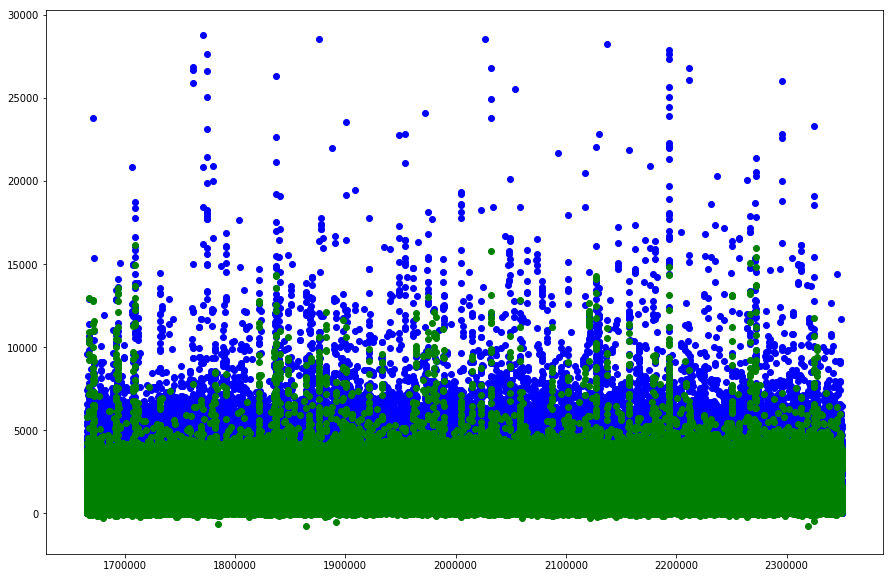

In [86]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()